In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

In [ ]:
U = 20                         # Number of Users
K = 1200                        # Number of Contents
si = np.ones((1, K))            # Content Size
Nu = 3                          # Recommended Contents for each user
alpha_u = np.random.rand(K) * 0.4 + 0.6  # The percentage of time a user u tends to follow the recommendations
rui = (np.random.randint(0, 5, (U, K)) + 1) / 5.0  # utility or relevance of a content i to the user u
Aui = np.random.rand(U, K) + 1
Rui = Aui * np.tanh(2 * rui)
nC = 4 # Number of Cache
kj = np.sort(np.random.rand(nC) * 0.002)   # Price of Caching 1 GB of Content
lambda1 = 0.12                # currency units per Gb requested

In [ ]:
# Optimization problem get inputs and return the values of U_CDN and U_CP

def optimization_problem(y0, alpha_u, Nu, Rui, si, lambda1, dis, Kui, U_CP0, U_CDN0):
    yui = cvx.Variable((U, K), boolean=True)
    UCP = cvx.sum(cvx.sum(cvx.multiply((alpha_u/Nu)*(Rui - si * lambda1 * (1+dis*(y0-1))), yui)))
    UCDN = cvx.sum(cvx.sum(cvx.multiply((alpha_u/Nu)*(si * lambda1 *(1+dis*(y0-1)) - Kui), yui)))

    obj = cvx.Maximize(cvx.log(UCP - U_CP0) + cvx.log(UCDN - U_CDN0))
    constr1 = cvx.sum(yui, 1) == Nu
    constr2 = UCP >= U_CP0
    constr3 = UCDN >= U_CDN0

    prob = cvx.Problem(obj, [constr1, constr2, constr3])
    prob.solve(solver=cvx.MOSEK)
    return UCP.value, UCDN.value, obj.value

In [ ]:
# Fig.3 Simulation

dis_a = np.array([0.05, 0.25, 0.4])
RelCache_a = np.array([0.01,0.02, 0.03, 0.04, 0.05, 0.1,0.2, 0.3])
U_CDN = np.zeros((len(dis_a), len(RelCache_a)))
U_CP = np.zeros((len(dis_a), len(RelCache_a)))

for d in range(len(dis_a)):
    for r in range(len(RelCache_a)):
        np.random.seed(25)
        
        # Scale the Rui in [0.2, 0.25]
        Rui = 0.05 * Rui / np.max(Rui) + 0.2
        
        dis = dis_a[d]                # reduction on the price
        
        # Relative Cache Size
        RelCache = RelCache_a[r]     # Relative Cache Size
        TotalCacheSize = np.sum(si) * RelCache
        
        
        C = np.zeros((1, nC))
        Size = np.floor(TotalCacheSize / nC)
        C[0, :] = Size
        C[0, -1] = TotalCacheSize - (nC-1) * Size
        C = C.astype('uint8')
        
        # Reserve Caches for contents
        X = np.zeros((K, nC), dtype = 'uint8')
        for j in range(nC):
            ind = np.random.choice(K, C[0,j])
            X[ind, j] = 1
        # Set C(u) show that each user connected to each Cache
        Cu = np.zeros((U, nC), dtype = 'uint8')
        for u in range(U):
            ind = np.random.choice(nC, 2)
            Cu[u, ind] = 1
        
        # Cost to show content i to user u
        Kui = np.zeros((U, K))
        
        for u in range(U):
            for i in range(K):
                is_set = False
                for j in range(nC):
                    if X[i, j] == 1 and Cu[u, j] == 1:
                        Kui[u, i] = si[0,i] * kj[j]
                        is_set = True
                        break
                if is_set == False:
                    Kui[u, i] = 0.05
        
        yui0 = cvx.Variable((U, K), boolean=True)
        UCP_0 = cvx.sum(cvx.sum(cvx.multiply((alpha_u/Nu)*(Rui - si * lambda1), yui0)))
        obj = cvx.Maximize(UCP_0)
        constr1 = cvx.sum(yui0, 1) == Nu
        prob = cvx.Problem(obj, [constr1])
        prob.solve()
        yui0 = yui0.value
        U_CP0 = UCP_0.value
        U_CDN0 = np.sum((alpha_u/Nu)*(si * lambda1 - Kui)*yui0)
        UCP, UCDN, obj = optimization_problem(yui0, alpha_u, Nu, Rui, si, lambda1, dis, Kui, U_CP0, U_CDN0)
        U_CDN[d, r] = 100 * (UCDN - U_CDN0) / U_CDN0
        U_CP[d, r] = 100 * (UCP - U_CP0) / U_CP0
        print('dis = ',dis,', RelCache = ',RelCache)
        print('U_CDN = ',U_CDN[d, r])
        print('U_CP  = ',U_CP[d, r])
        print(' ')


dis =  0.05 , RelCache =  0.01
U_CDN =  2.532458265010854
U_CP  =  0.6780718739534163
 
dis =  0.05 , RelCache =  0.02
U_CDN =  17.912056635165666
U_CP  =  2.4216990743287345
 
dis =  0.05 , RelCache =  0.03
U_CDN =  33.04404202995003
U_CP  =  2.7936680409259784
 
dis =  0.05 , RelCache =  0.04
U_CDN =  41.05193024062799
U_CP  =  3.316860200431675
 
dis =  0.05 , RelCache =  0.05
U_CDN =  45.06179484643911
U_CP  =  3.042496534152851
 
dis =  0.05 , RelCache =  0.1
U_CDN =  57.959548764216215
U_CP  =  3.7681890836065266
 
dis =  0.05 , RelCache =  0.2
U_CDN =  60.23019885201626
U_CP  =  3.724808493969094
 
dis =  0.05 , RelCache =  0.3
U_CDN =  61.21424035304395
U_CP  =  4.232352459372164
 
dis =  0.25 , RelCache =  0.01
U_CDN =  5.930330581515274
U_CP  =  3.5149292755241945
 
dis =  0.25 , RelCache =  0.02
U_CDN =  16.88927482795427
U_CP  =  12.875662870372892
 
dis =  0.25 , RelCache =  0.03
U_CDN =  22.49525782870847
U_CP  =  18.59756019906525
 
dis =  0.25 , RelCache =  0.04
U_CDN =

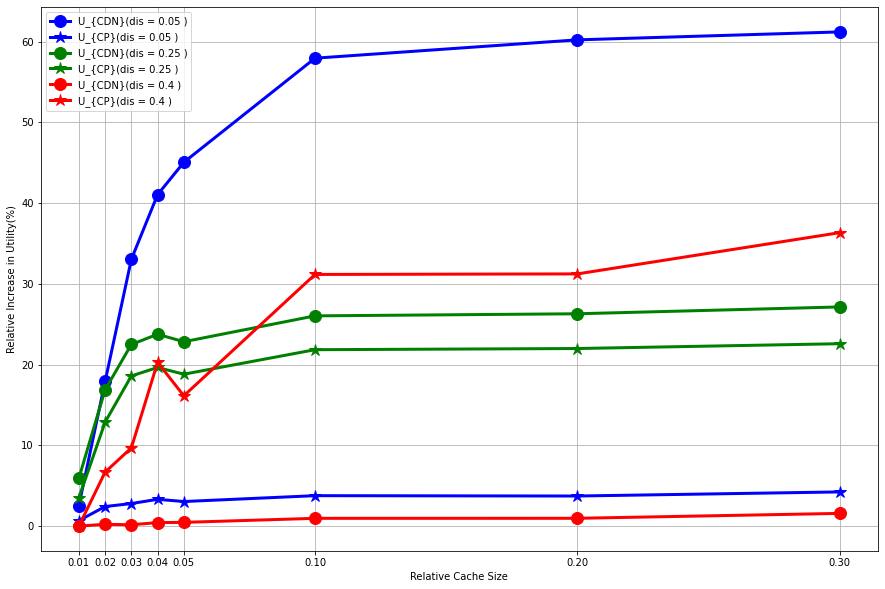

In [ ]:
# Fig.3 Plot results


colors = ['b', 'g', 'r']
formats = ['o-', '*-']

plt.figure(figsize = (15,10))
legendsTxt = []
for d in range(len(dis_a)):
    plt.plot(RelCache_a, U_CDN[d,:].T, colors[d]+formats[0], linewidth = 3, markersize = 12)
    legendsTxt.append('U_{CDN}(dis = ' + str(dis_a[d]) + ' )')
    plt.plot(RelCache_a, U_CP[d,:].T, colors[d]+formats[1], linewidth = 3, markersize = 12)
    legendsTxt.append('U_{CP}(dis = ' + str(dis_a[d]) + ' )')
plt.xlabel('Relative Cache Size')
plt.ylabel('Relative Increase in Utility(%)')
plt.legend(legendsTxt)
plt.xticks(RelCache_a)
plt.grid()
plt.show()

In [ ]:
# Fig.4 Simulation

dis_a = np.array([0.05, 0.2, 0.4])
Rui_Max = np.array([0.2, 0.3, 0.4, 0.5, 1])
U_CDN = np.zeros((1, len(Rui_Max)))
U_CP = np.zeros((1, len(Rui_Max)))

for d in range(len(Rui_Max)):
    
    R_min = 0.1
    R_max = Rui_Max[d]
    # Scale the Rui in [0.2, 0.25]
    Rui = (R_max- R_min) * Rui / np.max(Rui) + R_min
    dis = 0.05                    # reduction on the price

    # Relative Cache Size
    RelCache = 0.2                # Relative Cache Size
    TotalCacheSize = np.sum(si) * RelCache
    nC = 4 # Number of Cache
    C = np.zeros((1, nC))
    Size = np.floor(TotalCacheSize / nC)
    C[0, :] = Size
    C[0, -1] = TotalCacheSize - (nC-1) * Size
    C = C.astype('uint8')

    # Reserve Caches for contents
    X = np.zeros((K, nC), dtype = 'uint8')
    for j in range(nC):
        ind = np.random.choice(K, C[0,j])
        X[ind, j] = 1
    # Set C(u) show that each user connected to each Cache
    Cu = np.zeros((U, nC), dtype = 'uint8')
    for u in range(U):
        ind = np.random.choice(nC, 2)
        Cu[u, ind] = 1

    # Cost to show content i to user u
    Kui = np.zeros((U, K))

    for u in range(U):
        for i in range(K):
            is_set = False
            for j in range(nC):
                if X[i, j] == 1 and Cu[u, j] == 1:
                    Kui[u, i] = si[0,i] * kj[j]
                    is_set = True
                    break
            if is_set == False:
                Kui[u, i] = 0.05

    yui0 = cvx.Variable((U, K), boolean=True)
    UCP_0 = cvx.sum(cvx.sum(cvx.multiply((alpha_u/Nu)*(Rui - si * lambda1), yui0)))
    obj = cvx.Maximize(UCP_0)
    constr1 = cvx.sum(yui0, 1) == Nu
    prob = cvx.Problem(obj, [constr1])
    prob.solve()
    yui0 = yui0.value
    U_CP0 = UCP_0.value
    U_CDN0 = np.sum((alpha_u/Nu)*(si * lambda1 - Kui)*yui0)
    UCP, UCDN, obj = optimization_problem(yui0, alpha_u, Nu, Rui, si, lambda1, dis, Kui, U_CP0, U_CDN0)
    U_CDN[0, d] = 100 * (UCDN - U_CDN0) / U_CDN0
    U_CP[0, d] = 100 * (UCP - U_CP0) / U_CP0
    print('U_CDN[Rui is [',R_min,', ',R_max,')] = ',U_CDN[0, d])
    print('U_CP [Rui is [',R_min,', ',R_max,')] = ',U_CP[0, d])
    print(' ')

U_CDN[Rui is [ 0.1 ,  0.2 )] =  58.40484795900548
U_CP [Rui is [ 0.1 ,  0.2 )] =  5.422614421423059
 
U_CDN[Rui is [ 0.1 ,  0.3 )] =  60.51449153612569
U_CP [Rui is [ 0.1 ,  0.3 )] =  2.7035455110541573
 
U_CDN[Rui is [ 0.1 ,  0.4 )] =  54.76482954029479
U_CP [Rui is [ 0.1 ,  0.4 )] =  1.4467803063552611
 
U_CDN[Rui is [ 0.1 ,  0.5 )] =  58.622717737522805
U_CP [Rui is [ 0.1 ,  0.5 )] =  1.1737267527931292
 
U_CDN[Rui is [ 0.1 ,  1.0 )] =  42.5398763993906
U_CP [Rui is [ 0.1 ,  1.0 )] =  0.4422902353691763
 


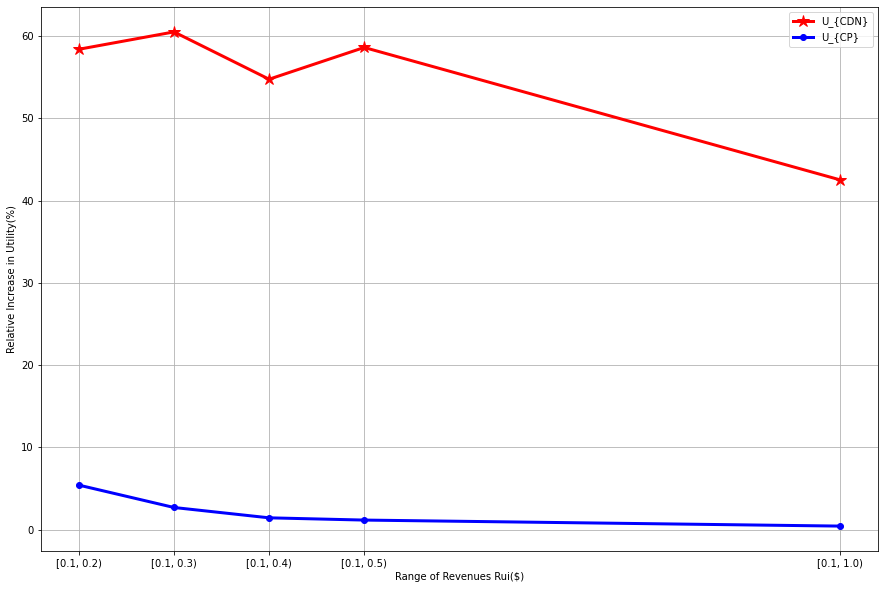

In [ ]:
# Fig.4 Plot results

labelsTxt = []
for d in range(len(Rui_Max)):
    labelsTxt.append('[0.1, '+str(Rui_Max[d]) + ')')
plt.figure(figsize = (15,10))
plt.plot(Rui_Max, U_CDN.T,'r*-', linewidth = 3, markersize = 12)
plt.plot(Rui_Max, U_CP.T,'b.-', linewidth = 3, markersize = 12)
plt.xlabel('Range of Revenues Rui($)')
plt.ylabel('Relative Increase in Utility(%)')
plt.xticks(Rui_Max, labelsTxt)
plt.legend(['U_{CDN}', 'U_{CP}'])
plt.grid()
plt.show()


In [ ]:
# Fig.5 Simulation

dis_a = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.5, 0.57])
Objetive_a = np.zeros((1, len(dis_a)))
U_CDN = np.zeros((1, len(dis_a)))
U_CP = np.zeros((1, len(dis_a)))
# Scale the Rui in [0.2, 0.25]
Rui = 0.05 * Rui / np.max(Rui) + 0.2



# Relative Cache Size
RelCache = RelCache_a[r]     # Relative Cache Size
TotalCacheSize = np.sum(si) * RelCache


C = np.zeros((1, nC))
Size = np.floor(TotalCacheSize / nC)
C[0, :] = Size
C[0, -1] = TotalCacheSize - (nC-1) * Size
C = C.astype('uint8')

# Reserve Caches for contents
X = np.zeros((K, nC), dtype = 'uint8')
for j in range(nC):
    ind = np.random.choice(K, C[0,j])
    X[ind, j] = 1
# Set C(u) show that each user connected to each Cache
Cu = np.zeros((U, nC), dtype = 'uint8')
for u in range(U):
    ind = np.random.choice(nC, 2)
    Cu[u, ind] = 1

# Cost to show content i to user u
Kui = np.zeros((U, K))

for u in range(U):
    for i in range(K):
        is_set = False
        for j in range(nC):
            if X[i, j] == 1 and Cu[u, j] == 1:
                Kui[u, i] = si[0,i] * kj[j]
                is_set = True
                break
        if is_set == False:
            Kui[u, i] = 0.05

yui0 = cvx.Variable((U, K), boolean=True)
UCP_0 = cvx.sum(cvx.sum(cvx.multiply((alpha_u/Nu)*(Rui - si * lambda1), yui0)))
obj = cvx.Maximize(UCP_0)
constr1 = cvx.sum(yui0, 1) == Nu
prob = cvx.Problem(obj, [constr1])
prob.solve()
yui0 = yui0.value
U_CP0 = UCP_0.value
U_CDN0 = np.sum((alpha_u/Nu)*(si * lambda1 - Kui)*yui0)

for d in range(len(dis_a)):
    dis = dis_a[d]                # reduction on the price
    UCP, UCDN, obj = optimization_problem(yui0, alpha_u, Nu, Rui, si, lambda1, dis, Kui, U_CP0, U_CDN0)
    Objetive_a[0, d] = obj
    U_CDN[0, d] = 100 * (UCDN - U_CDN0) / U_CDN0
    U_CP[0, d] = 100 * (UCP - U_CP0) / U_CP0
    print('Obj  [dis = ',dis,'] = ',Objetive_a[0, d])
    print('U_CDN[dis = ',dis,'] = ',U_CDN[0, d])
    print('U_CP [dis = ',dis,'] = ',U_CP[0, d])
    print(' ')


Obj  [dis =  0.01 ] =  -4.618439143708344
U_CDN[dis =  0.01 ] =  34.41552315567559
U_CP [dis =  0.01 ] =  0.6396373510747569
 
Obj  [dis =  0.02 ] =  -3.744540331888014
U_CDN[dis =  0.02 ] =  34.90881192667447
U_CP [dis =  0.02 ] =  1.51106294262273
 
Obj  [dis =  0.05 ] =  -2.8322888928669214
U_CDN[dis =  0.05 ] =  30.750718190175387
U_CP [dis =  0.05 ] =  4.2711824788269706
 
Obj  [dis =  0.1 ] =  -2.356714817816749
U_CDN[dis =  0.1 ] =  23.820540937160686
U_CP [dis =  0.1 ] =  8.871375590661454
 
Obj  [dis =  0.2 ] =  -2.260230688508829
U_CDN[dis =  0.2 ] =  18.880691381929005
U_CP [dis =  0.2 ] =  12.326143447772118
 
Obj  [dis =  0.4 ] =  -4.670968721298359
U_CDN[dis =  0.4 ] =  0.8627979704989023
U_CP [dis =  0.4 ] =  24.208382416940402
 
Obj  [dis =  0.5 ] =  -33.067307763978505
U_CDN[dis =  0.5 ] =  1.5476900616701041e-06
U_CP [dis =  0.5 ] =  6.277945479713788e-06
 
Obj  [dis =  0.57 ] =  -32.433566516906225
U_CDN[dis =  0.57 ] =  2.5788657820866267e-06
U_CP [dis =  0.57 ] =  

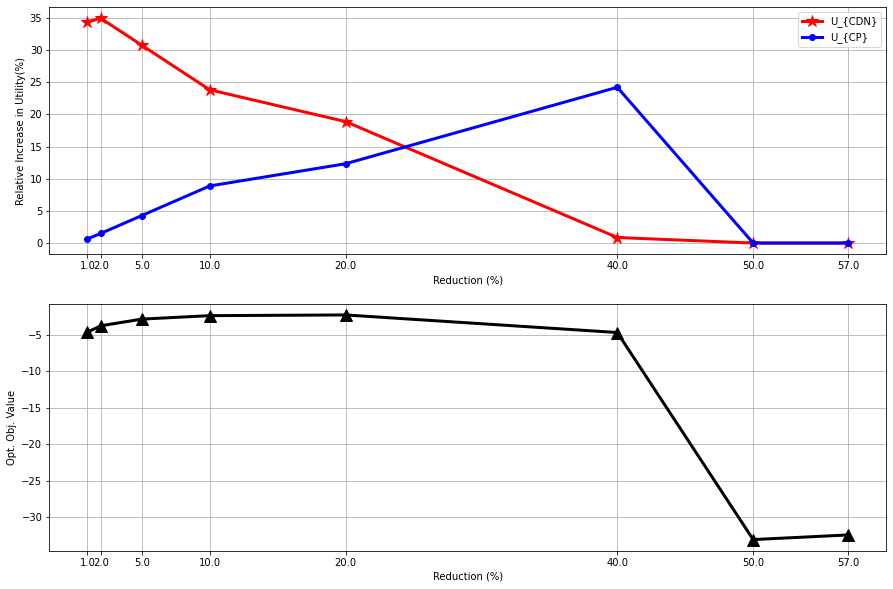

In [ ]:
# Fig.5 Plot results

plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(dis_a, U_CDN.T,'r*-', linewidth = 3, markersize = 12)
plt.plot(dis_a, U_CP.T,'b.-', linewidth = 3, markersize = 12)
plt.xlabel('Reduction (%)')
plt.ylabel('Relative Increase in Utility(%)')
plt.xticks(dis_a, np.round(dis_a * 100))
plt.grid()
plt.legend(['U_{CDN}', 'U_{CP}'])
plt.subplot(2,1,2)
plt.plot(dis_a, Objetive_a.T,'k^-', linewidth = 3, markersize = 12)
plt.xlabel('Reduction (%)')
plt.ylabel('Opt. Obj. Value')
plt.xticks(dis_a, np.round(dis_a * 100))
plt.grid()
plt.show()